## Imports

In [48]:
# Initialize global variables
import ml_args
ml_args.init()

# Global imports
import numpy as np
from sklearn.model_selection import train_test_split

# Torch library
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Local imports
from load_data import *
from raster_convert import *
from output_display import *
from extract_dataset import *

## Build 3D rasters

In [ ]:
ml_dataset_import(ml_args.dataset_low_res, ml_args.raster_low_res, ml_args.width_low_res)
ml_dataset_import(ml_args.dataset_high_res, ml_args.raster_high_res, ml_args.width_high_res)

## Load the data

In [50]:
ml_data_low_res = get_ml_data(ml_args.raster_low_res)
ml_data_high_res = get_ml_data(ml_args.raster_high_res)

## Build Torch Tensors from the data

In [53]:
class CloudPointDataset(Dataset):
    ''' Class of cloudpoint data that will be usable by Pytorch '''

    def __init__(self, thin_dataset, thick_dataset, train, transform=None):
        """
        Args:
            mat_file (string): Path to the mat file with the data
            train (boolean): Is it the training data or the test data
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.X = thin_dataset
        self.Y = thick_dataset
        self.X = np.asarray(self.X).astype(float)
        self.Y = np.asarray(self.Y).astype(float)
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(self.X, self.Y, test_size=0.3, random_state=1)
        self.Xtrain, self.Xtest = Xtrain, Xtest
        self.Ytrain, self.Ytest = Ytrain, Ytest
        self.train = train
        self.transform = transform

    def __len__(self):
        if self.train:
            return (self.Xtrain.shape[0])
        else:
            return (self.Xtest.shape[0])

    def __getitem__(self, idx):
        
        if self.train:
            sample = {'image': self.Xtrain[idx,:], 'label': self.Ytrain[idx,:]}
        else:
            sample = {'image': self.Xtest[idx,:], 'label': self.Ytest[idx,:]}
            
        if self.transform:
            sample = self.transform(sample)

        return sample

In [54]:
class ToTensor(object):
    ''' Convert ndarrays in sample to Tensors. '''

    def __call__(self, sample):
        raster, label = sample['image'], sample['label']
        raster = torch.from_numpy(raster).float()
        raster = raster.expand(1, 16, 16, 16)
        return {'image': raster, 'label': label}

In [55]:
# Define the trainset and testset and put them in the form of a torch tensor
trainset = CloudPointDataset(ml_data_low_res, ml_data_high_res, train=True, transform = ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 1, shuffle=False, num_workers=10)

testset = CloudPointDataset(ml_data_low_res, ml_data_high_res, train=False, transform=ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size = 1, shuffle=False, num_workers=10)

## Define the model & CNN architecture

In [56]:
class Net(nn.Module):
    def __init__(self):
        ''' Define the functions that are to be used in the CNN '''
        
        super(Net, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, 3, padding = 1, stride = 1)
        self.conv2 = nn.Conv3d(32, 32, 3, padding = 1, stride = 1)
        self.conv3 = nn.Conv3d(32, 64, 3, padding = 1, stride = 1)
        self.conv4 = nn.Conv3d(64, 64, 3, padding = 1, stride = 1)
        self.conv5 = nn.Conv3d(64, 1, 3, padding = 1, stride = 1)
        self.BN = nn.BatchNorm3d(num_features = 32)
        
    def forward(self, x):
        ''' Define the architecture of the CNN '''
        
        # Empty storage vector
        x_ = []
        
        # Augment the number of layers from 1 to 32
        x = self.conv1(x)
        x = self.BN(x)
        x = F.relu(x)
        x_.append(x)
        
        # 6 residual blocks (core CNN)
        for i in range(6):
            x = self.conv2(x)
            x = self.BN(x)
            x = F.relu(x)
            x = self.conv2(x)
            x = self.BN(x)
            x = x + x_[-1]
            x_.append(x)
        
        x = self.conv2(x)
        x = self.BN(x)
        x = x + x_[0]
        
        # Augment the number of layers from 32 to 64
        x = self.conv3(x)
        x = F.relu(x)
        
        # Two-step interpolation to the higher resolution
        x = nn.functional.interpolate(x, size = (24, 24, 24), mode='trilinear')
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x) 
        x = nn.functional.interpolate(x, size = (32, 32, 32), mode='trilinear')
        x = self.conv4(x)
        x = F.relu(x)
        
        # Reduce the number of layers again from 64 to 1
        x = self.conv5(x)        
        
        return x

model = Net()

In [57]:
# Define the criterion (loss function) and the optimizer (here : stochastic gradient descent)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.8)

# Train the model

### Train outputs description

In [ ]:
print('Outputs dimensions:',len(outputs), len(outputs[0]), len(outputs[0][0]))

In [ ]:
print('Low resolution data dimensions:', len(x), len(x[0]), 
      len(x[0][0]), len(x[0][0][0]))

In [ ]:
print('High resolution data dimensions:', len(y), len(y[0]), 
      len(y[0][0]), len(y[0][0][0]), len(y[0][0][0][0]))

In [ ]:
print('Super-resolution data dimensions:', len(y_hat), len(y_hat[0]),
      len(y_hat[0][0]), len(y_hat[0][0][0]), len(y_hat[0][0][0][0]))

# Or Load the pre-trained model

In [58]:
model = Net()
y_hat_, y_, x_ = [], [], []

with torch.no_grad():

    for i, data in enumerate(testloader, 0):

        checkpoint = torch.load('./model/2000/model_epoch_4')
        model.load_state_dict(checkpoint['model_state_dict'])
    
        images, labels = data['image'], data['label'].float()
        images, labels = Variable(images), Variable(labels)
    
        model.eval()
    
        outputs = model(images)
        outputs = np.squeeze(outputs, axis=1)
        
        y_hat_.append(outputs)
        x_.append(images)
        y_.append(labels)

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


### Test outputs description

In [39]:
print('Outputs dimensions:', len(outputs), len(outputs[0]), len(outputs[0][0]))

32 32 32


In [40]:
print('Low resolution data dimensions:', len(x_), len(x_[0]), 
      len(x_[0][0]), len(x_[0][0][0]))

1500 32 32 32


In [ ]:
print('High resolution data dimensions:', len(y_), len(y_[0]), 
      len(y_[0][0]), len(y_[0][0][0]), len(y_[0][0][0][0]))

In [ ]:
print('Super-resolution data dimensions:', len(y_hat_), len(y_hat_[0]),
      len(y_hat_[0][0]), len(y_hat_[0][0][0]), len(y_hat_[0][0][0][0]))

# Print the output

In [20]:
%matplotlib
'''#%matplotlib qt # comment if you want to plot inline'''
%matplotlib inline 
# comment if you want to plot in interactive 3D

Using matplotlib backend: MacOSX


In [44]:
# Pick a raster you want to see
# (NB : learning is random => ordering will change each time you train the model)
n = 1480

True

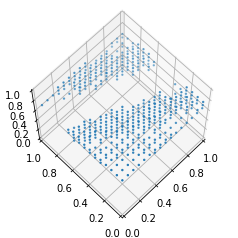

In [45]:
print_3D(x_, n, mode = 'x')

True

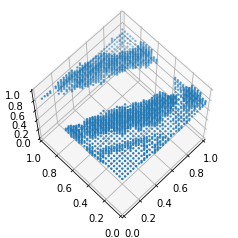

In [46]:
print_3D(y_, n, mode = 'y')

True

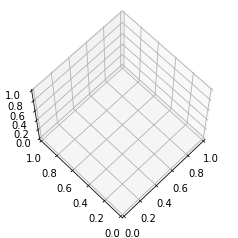

In [47]:
print_3D_pred(y_hat_, n)